In [1]:
%pip install pandas -q
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
    
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

2025-08-01 13:20:36.061649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 13:20:36.076627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754043636.092460   68132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754043636.096767   68132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754043636.110552   68132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [4]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bicubic', # bicubic bilinear
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [5]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.


I0000 00:00:1754043639.328587   68132 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

# for images, labels in df_train.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
#         plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
#         plt.axis("off")
#     plt.show()

Классы: ['NORMAL', 'PNEUMONIA']


In [7]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


In [8]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1069 изображений
Класс PNEUMONIA (1): 3139 изображений


2025-08-01 13:20:43.005134: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

In [10]:
# Функция для нормализации
def normalize_img(image, label):
    """Приводит значения пикселей к диапазону [0, 1]."""
    return tf.cast(image, tf.float32) / 255.0, label

# Функция аугментации и нормализации для ТРЕНИРОВОЧНЫХ данных
def augment_and_normalize_train(image, label):
    """Применяет аугментацию и затем нормализует изображение."""
    image_augmented = data_augmentation_pipeline(image, training=True)
    return tf.cast(image_augmented, tf.float32) / 255.0, label

# Применяем новые функции к нашим датасетам
# Важно: аугментацию применяем ТОЛЬКО к df_train
df_train_processed = df_train.map(augment_and_normalize_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [11]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train_processed:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1073 изображений
Класс PNEUMONIA (1): 3135 изображений


2025-08-01 13:20:46.677576: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# рассчитаем class_weights
# сделаем это через кол-во элементов одного и второго класса
labels = np.concatenate([y for x, y in df_train_processed], axis=0)
normal_count = np.sum(labels == 0)
pneumonia_count = np.sum(labels == 1)
total_count = len(labels)

weight_for_0 = (1 / normal_count) * (total_count / 2)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

In [13]:
# создадим модель
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=1e-4), 
    metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
model.summary()

/home/koziy/projects/xray_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           25

 Total params: 26,215,041 (100.00 MB)

 Trainable params: 26,212,545 (99.99 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [14]:
# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=20,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/20


I0000 00:00:1754043651.567320   68333 service.cc:152] XLA service 0x76eb74008c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754043651.567349   68333 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-08-01 13:20:51.733439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754043652.344822   68333 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/132 ━━━━━━━━━━━━━━━━━━━━ 23:56 11s/step - accuracy: 0.6562 - auc: 0.5938 - loss: 0.7062 - precision: 0.8421 - recall: 0.6667

I0000 00:00:1754043661.467637   68333 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7827 - auc: 0.9085 - loss: 0.4322 - precision: 0.9567 - recall: 0.7394

132/132 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.7830 - auc: 0.9087 - loss: 0.4318 - precision: 0.9568 - recall: 0.7397 - val_accuracy: 0.7305 - val_auc: 0.5000 - val_loss: 1.5530 - val_precision: 0.7305 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8706 - auc: 0.9652 - loss: 0.2744 - precision: 0.9815 - recall: 0.8423 - val_accuracy: 0.7256 - val_auc: 0.5000 - val_loss: 3.0864 - val_precision: 0.7256 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8942 - auc: 0.9679 - loss: 0.2512 - precision: 0.9729 - recall: 0.8808

132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8941 - auc: 0.9679 - loss: 0.2512 - precision: 0.9730 - recall: 0.8808 - val_accuracy: 0.7305 - val_auc: 0.8868 - val_loss: 1.0041 - val_precision: 0.7299 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
110/132 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9022 - auc: 0.9728 - loss: 0.2278 - precision: 0.9797 - recall: 0.8869

132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9028 - auc: 0.9729 - loss: 0.2272 - precision: 0.9796 - recall: 0.8879 - val_accuracy: 0.7891 - val_auc: 0.9757 - val_loss: 0.4065 - val_precision: 0.7762 - val_recall: 0.9973 - learning_rate: 1.0000e-04
Epoch 5/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9186 - auc: 0.9777 - loss: 0.2045 - precision: 0.9862 - recall: 0.9030

132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.9186 - auc: 0.9777 - loss: 0.2045 - precision: 0.9861 - recall: 0.9031 - val_accuracy: 0.9570 - val_auc: 0.9889 - val_loss: 0.1407 - val_precision: 0.9807 - val_recall: 0.9596 - learning_rate: 1.0000e-04
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9138 - auc: 0.9752 - loss: 0.2117 - precision: 0.9782 - recall: 0.9040 - val_accuracy: 0.9375 - val_auc: 0.9872 - val_loss: 0.2613 - val_precision: 0.9971 - val_recall: 0.9172 - learning_rate: 1.0000e-04
Epoch 7/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9232 - auc: 0.9780 - loss: 0.1913 - precision: 0.9820 - recall: 0.9133
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9232 - auc: 0.9780 - loss: 0.1914 - precision: 0.9819 - recall: 0.9133 - val_accuracy: 0.9629 - val_auc: 0.9939 - val_loss: 0.1484 - val_precision: 0.9931 - val_recall: 0.9562 - learning_rate: 1.0

In [18]:
# # Извлекаем данные из истории обучения
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Создаем массив эпох для оси X
# epochs_range = range(len(acc))

# # Создаем фигуру для графиков
# plt.figure(figsize=(14, 6))

# # --- График точности (Accuracy) ---
# plt.subplot(1, 2, 1) # 1 строка, 2 колонки, 1-й график
# plt.plot(epochs_range, acc, label='Точность на обучении (Train Accuracy)')
# plt.plot(epochs_range, val_acc, label='Точность на валидации (Validation Accuracy)')
# plt.legend(loc='lower right')
# plt.title('График точности (Accuracy)')
# plt.xlabel('Эпохи')
# plt.ylabel('Точность')

# # --- График потерь (Loss) ---
# plt.subplot(1, 2, 2) # 1 строка, 2 колонки, 2-й график
# plt.plot(epochs_range, loss, label='Потери на обучении (Train Loss)')
# plt.plot(epochs_range, val_loss, label='Потери на валидации (Validation Loss)')
# plt.legend(loc='upper right')
# plt.title('График потерь (Loss)')
# plt.xlabel('Эпохи')
# plt.ylabel('Потери')

# # Показываем графики
# plt.show()

In [16]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7611 - auc: 0.6274 - loss: 0.5766 - precision: 0.4321 - recall: 0.6583    
Test Loss: 0.3735050559043884
Test Accuracy: 0.8493589758872986


___
    bilinear - 512, 256 - Dropout 0.2:
    Test Loss: 0.44560882449150085
    Test Accuracy: 0.8365384340286255

    Test Loss: 0.43897607922554016
    Test Accuracy: 0.8509615659713745

    Test Loss: 0.43657195568084717
    Test Accuracy: 0.8285256624221802

    Test Loss: 0.5391685366630554
    Test Accuracy: 0.8221153616905212
    


    bicubic - 512, 256 - Dropout 0.2:
    Test Loss: 0.48813432455062866
    Test Accuracy: 0.8012820482254028

    Test Loss: 0.4249945282936096
    Test Accuracy: 0.8253205418586731

    Test Loss: 0.4015040099620819
    Test Accuracy: 0.8525640964508057

    Test Loss: 0.37690848112106323
    Test Accuracy: 0.8766025900840759
___

___
    nearest - 1024 - Dropout 0.1:
    Test Loss: 0.544722855091095
    Test Accuracy: 0.8669871687889099

    Test Loss: 0.43557313084602356
    Test Accuracy: 0.8637820482254028

    Test Loss: 0.29153913259506226
    Test Accuracy: 0.9022436141967773
    
    
    bicubic - 1024 - Dropout 0.1:
    Test Loss: 0.49374815821647644
    Test Accuracy: 0.8413461446762085
    
    Test Loss: 0.5249808430671692
    Test Accuracy: 0.8557692170143127

    Test Loss: 0.7832591533660889
    Test Accuracy: 0.8044871687889099

    Test Loss: 0.8190344572067261
    Test Accuracy: 0.7756410241127014

    Test Loss: 0.43044447898864746
    Test Accuracy: 0.8589743375778198



    bilinear - 1024 - Dropout 0.1:
    Test Loss: 0.29838675260543823
    Test Accuracy: 0.9054487347602844

    Test Loss: 0.3353724777698517
    Test Accuracy: 0.9102563858032227

    Test Loss: 0.4571737051010132
    Test Accuracy: 0.8782051205635071

    Test Loss: 0.5393040180206299
    Test Accuracy: 0.8269230723381042

    Test Loss: 0.7869371771812439
    Test Accuracy: 0.7676281929016113

    Test Loss: 0.6194705367088318
    Test Accuracy: 0.8349359035491943    

    Test Loss: 0.5169366002082825
    Test Accuracy: 0.8509615659713745
___

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


2025-08-01 13:22:57.109531: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


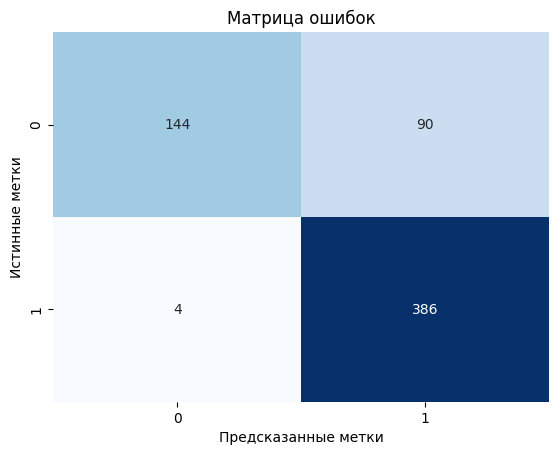

              precision    recall  f1-score   support

      NORMAL       0.97      0.62      0.75       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



In [17]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))